# Experiment 2 - Text-to-vector

The goal of this notebook is to try and improve the neural network. To do this, the main focus improving the way in which we vectorize the text. As this was an essential part of the course, we felt that we wanted to dive into text embedding to see if we could extract relevant information from this text. For this we use three methods:

- TFIDF with english word lemmatizer
- TFIDF with italian word lemmatizer
- Transformer word embedding, to obtain more of the actual meaning of the text

The conclusion is that none of these methods strongly improved the predictions that could be made using the text. It seems that the text column is just not as informative or relevant as we had assumed. Therefore, in the next notebook `n4`_refining_features we investigate opportunities in refining the number of input features.

In [12]:
import pandas as pd

# Load the Excel file
file_path = '../data/luiss_data_anonym.xlsx'
df = pd.read_excel(file_path)

In [13]:
# Delete all rows for which IvaM is missing because this is the value we want to predict
df = df[~df.IvaM.isna()]

# Calculate number of NaNs per column
nans_per_column = df.isnull().sum()

# Calculate percentage of NaNs per column
percentage_nans_per_column = (df.isnull().sum() / len(df)) * 100

# Display as dataframe
nans_df = pd.DataFrame({'Number of NaNs': nans_per_column, 'Percentage of NaNs': percentage_nans_per_column})

In [14]:
# To improve our insights in successfulness of methods, now we do not
# want to have "" empty strings as text.
df = df[~df["DescrizioneRiga"].isnull()]

In [15]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
nlp = spacy.load("it_core_news_sm")
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score
from nltk.stem import WordNetLemmatizer
from joblib import dump, load
import re
import nltk
import seaborn as sns
from sklearn.metrics import confusion_matrix
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\20202034\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
# ALL COLUMNS

df = df.drop(columns=['Unnamed: 0'])
# Split the dataset into features and target variable
X = df.drop('IvaM', axis=1)
y = df[['IvaM']]

# One hot encode target variable.
encoder = OneHotEncoder()
encoded_y = encoder.fit_transform(y[['IvaM']])
encoded_y = encoded_y.toarray() 

## English TF-IDF

In [17]:
# Text column preprocessing
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

text_transformer = TfidfVectorizer()
text_features = 'DescrizioneRiga' 
X[text_features] = X[text_features].apply(preprocess_text)
vectorized_text_X = text_transformer.fit_transform(X[text_features])
svd = TruncatedSVD(n_components=1000)
X_reduced_text_tfidf_eng = svd.fit_transform(vectorized_text_X)
print(f"Explained variance ratio: {sum(svd.explained_variance_ratio_)}")

Explained variance ratio: 0.6097135916937982


Epoch 1/10
2994/2994 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7097 - loss: 1.1913 - val_accuracy: 0.8457 - val_loss: 0.5236
Epoch 2/10
2994/2994 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8572 - loss: 0.4926 - val_accuracy: 0.8651 - val_loss: 0.4751
Epoch 3/10
2994/2994 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8732 - loss: 0.4231 - val_accuracy: 0.8729 - val_loss: 0.4361
Epoch 4/10
2994/2994 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8891 - loss: 0.3665 - val_accuracy: 0.8826 - val_loss: 0.4142
Epoch 5/10
2994/2994 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9001 - loss: 0.3272 - val_accuracy: 0.8813 - val_loss: 0.4090
Epoch 6/10
2994/2994 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9043 - loss: 0.3059 - val_accuracy: 0.8875 - val_loss: 0.4000
Epoch 7/10
2994/2994 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9118 - loss: 0.2761 - val_accuracy: 0.8896 - val_loss: 0.4076
Epoch 8/10
2994/2994 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9177 - loss: 0.2555 - 

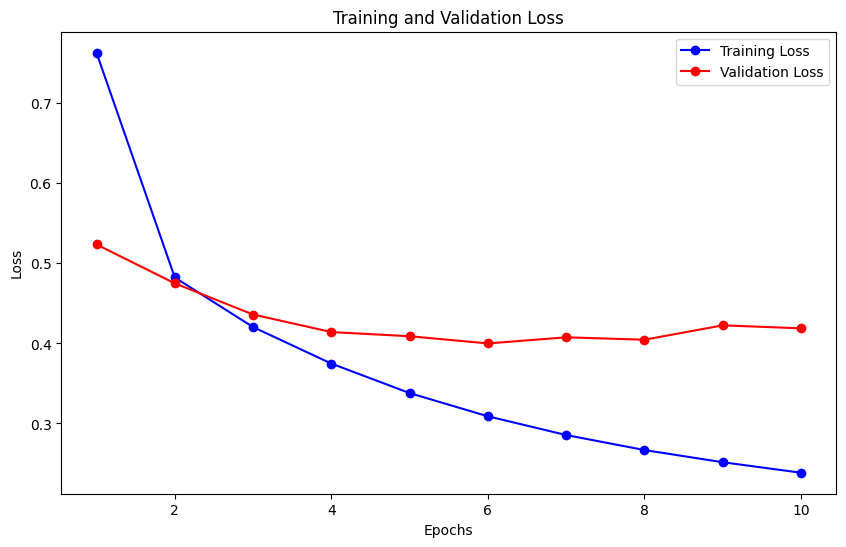

832/832 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8850 - loss: 0.4324
Test Accuracy: 0.8858076930046082
Test Loss: 0.43536171317100525
832/832 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step   


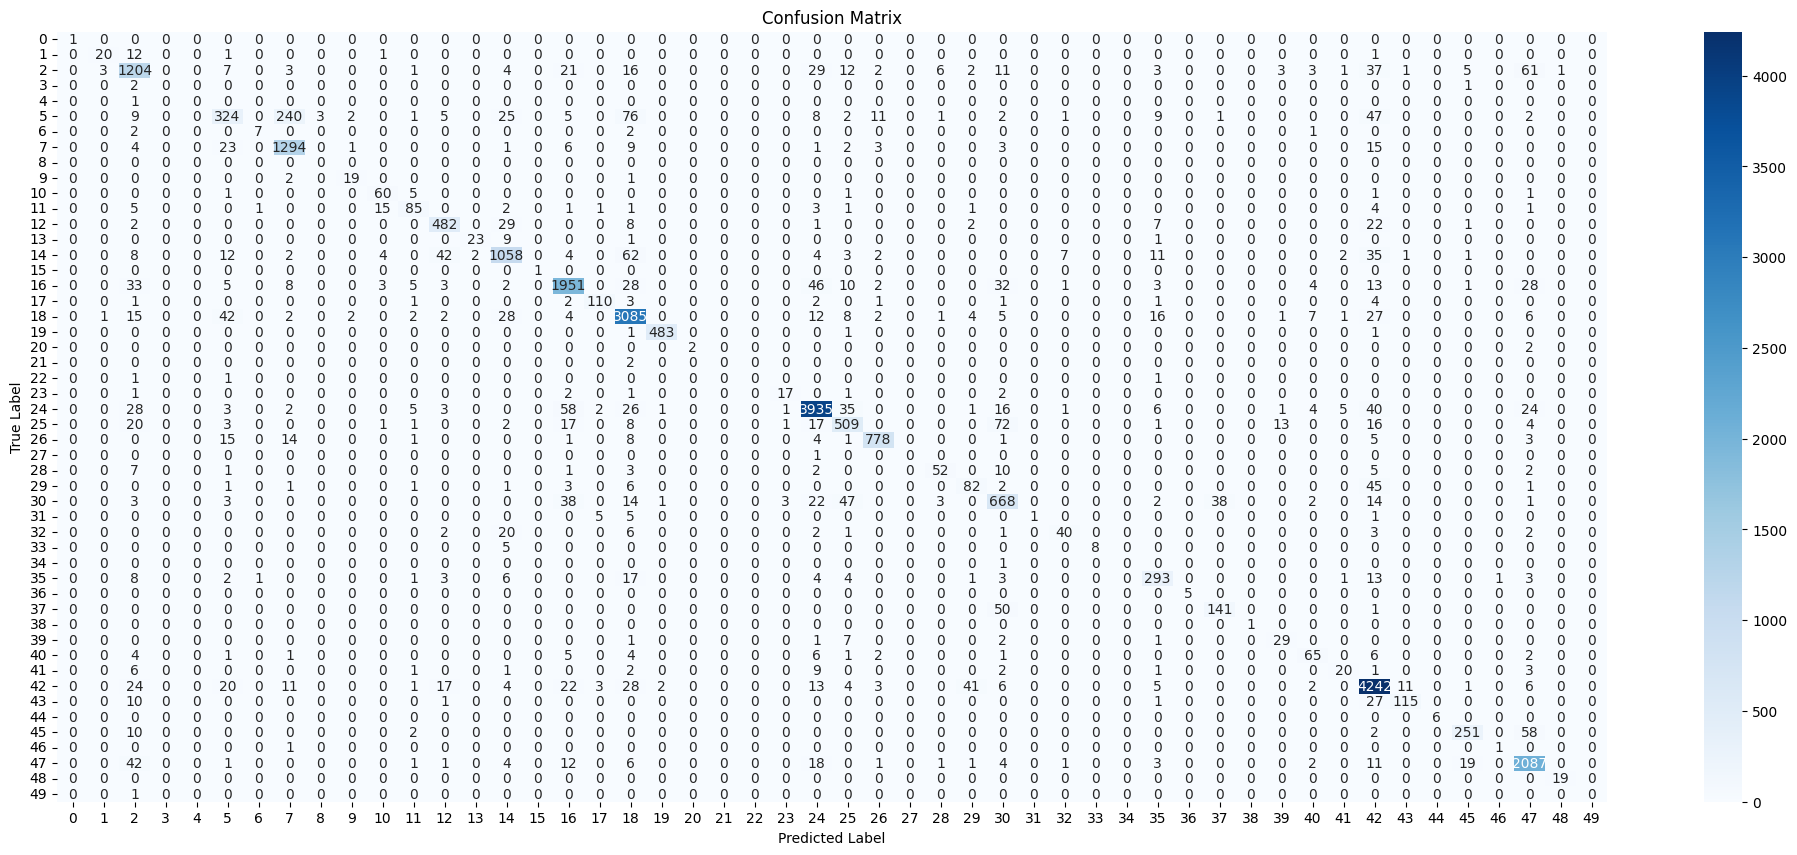

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced_text_tfidf_eng, encoded_y, test_size=0.2, random_state=42)
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

model = keras.Sequential([
  keras.layers.Dense(units=256, activation="relu"),  
  keras.layers.Dense(units=128, activation="relu"),  
  keras.layers.Dense(units=60, activation="softmax"),  
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(X_train_new, y_train_new, epochs=10, batch_size=32, validation_data=(X_val, y_val))

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Find test accuracy
test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

y_pred = model.predict(X_test)

# convert one-hot encoded prediction to class label prediciton
y_pred2 = np.argmax(y_pred, axis=1)
y_test2 = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_test2, y_pred2)

# Plot the confusion matrix
plt.figure(figsize=(25, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Italian TF-IDF

In [25]:
# Process the text using an italian language model for lemmatization
def preprocess_text_italian(text):
    text = str(text).lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    doc = nlp(text)
    words = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(words)

text_transformer = TfidfVectorizer()
text_features = 'DescrizioneRiga'  # Your text column name
X[text_features] = X[text_features].apply(preprocess_text_italian)
# When running for the first time
# vectorized_text_X = text_transformer.fit_transform(X[text_features])
# Save the fitted TfidfVectorizer to disk --> this way we can easily reuse it, when testing new examples
# dump(text_transformer, '../assets/text_vectorizer_tfidf_italian.joblib')
# When re-running:
text_transformer = load('../assets/text_vectorizer_tfidf_italian.joblib')
vectorized_text_X = text_transformer.transform(X[text_features])
svd = TruncatedSVD(n_components=1000)
X_reduced_text_tfidf_it = svd.fit_transform(vectorized_text_X)
print(f"Explained variance ratio: {sum(svd.explained_variance_ratio_)}")

Explained variance ratio: 0.609553653010495


Epoch 1/10
2994/2994 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6981 - loss: 1.2228 - val_accuracy: 0.8416 - val_loss: 0.5669
Epoch 2/10
2994/2994 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8507 - loss: 0.5294 - val_accuracy: 0.8555 - val_loss: 0.4994
Epoch 3/10
2994/2994 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8639 - loss: 0.4620 - val_accuracy: 0.8648 - val_loss: 0.4691
Epoch 4/10
2994/2994 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8790 - loss: 0.4048 - val_accuracy: 0.8699 - val_loss: 0.4533
Epoch 5/10
2994/2994 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8876 - loss: 0.3675 - val_accuracy: 0.8736 - val_loss: 0.4458
Epoch 6/10
2994/2994 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8952 - loss: 0.3393 - val_accuracy: 0.8785 - val_loss: 0.4433
Epoch 7/10
2994/2994 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9008 - loss: 0.3181 - val_accuracy: 0.8766 - val_loss: 0.4490
Epoch 8/10
2994/2994 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9077 - loss: 0.2924 -

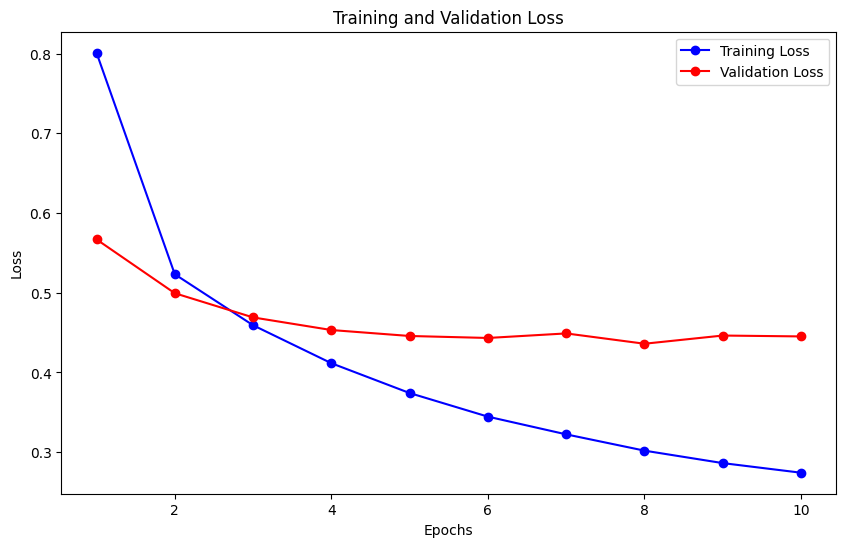

832/832 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8748 - loss: 0.4716
Test Accuracy: 0.8760756254196167
Test Loss: 0.4775262475013733
832/832 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


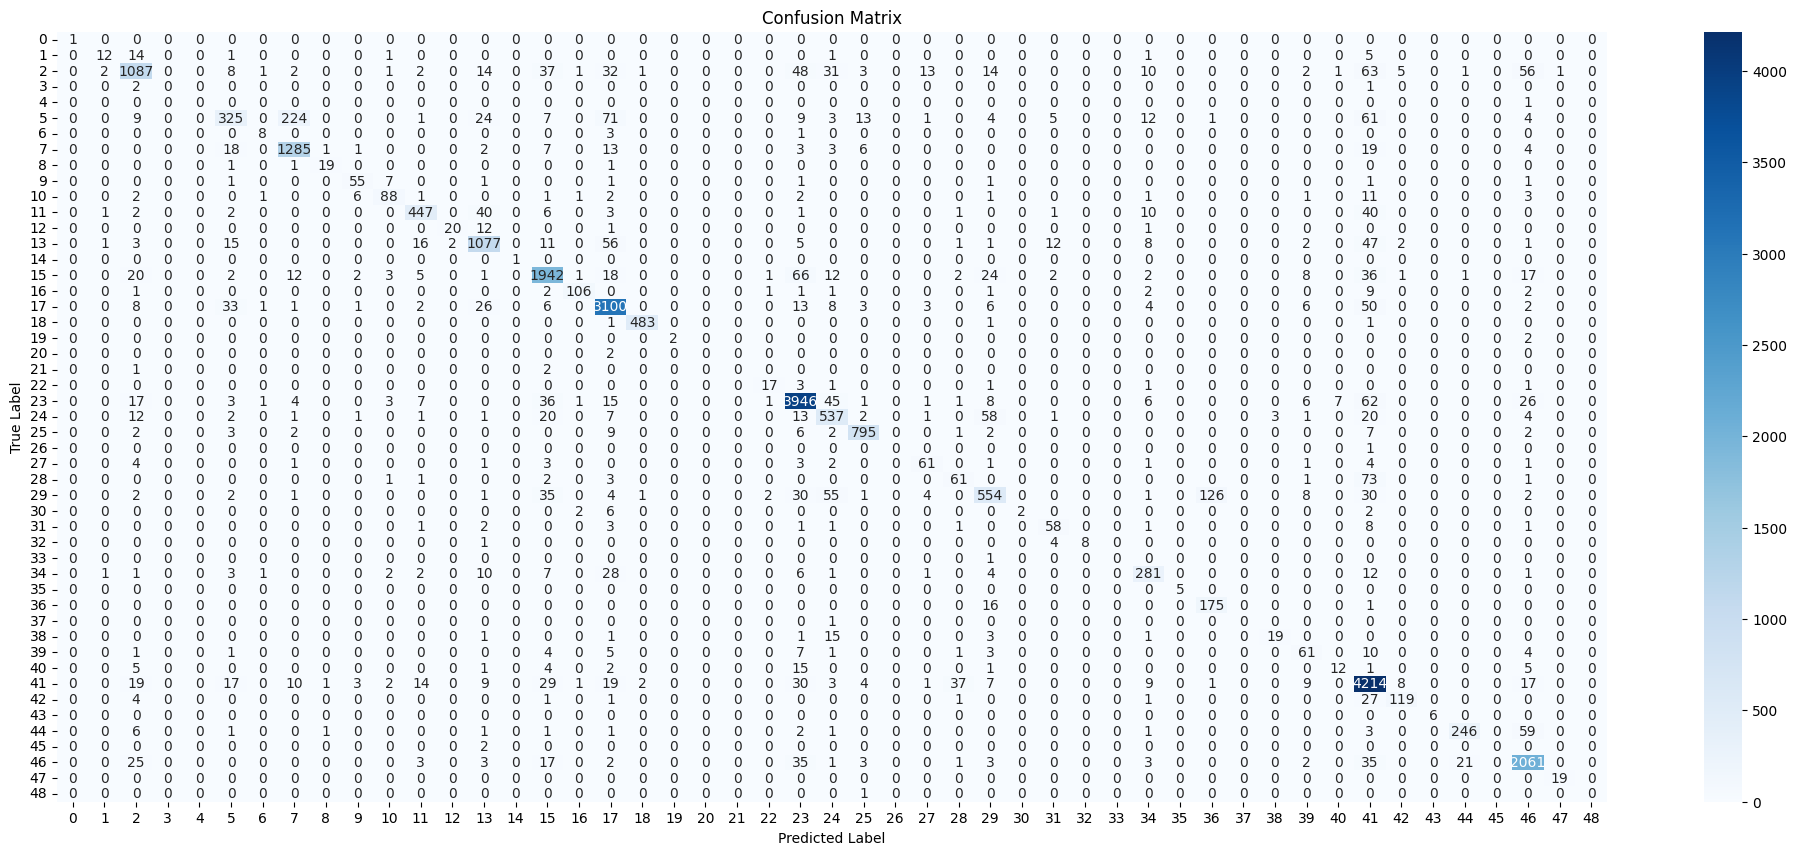

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced_text_tfidf_it, encoded_y, test_size=0.2, random_state=42)
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

model = keras.Sequential([
  keras.layers.Dense(units=256, activation="relu"),  
  keras.layers.Dense(units=128, activation="relu"),  
  keras.layers.Dense(units=60, activation="softmax"),  
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(X_train_new, y_train_new, epochs=10, batch_size=32, validation_data=(X_val, y_val))

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Find test accuracy
test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

y_pred = model.predict(X_test)

# convert one-hot encoded prediction to class label prediciton
y_pred2 = np.argmax(y_pred, axis=1)
y_test2 = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_test2, y_pred2)

# Plot the confusion matrix
plt.figure(figsize=(25, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Transformer embedding

In [21]:
# Has to be run the first time (takes long approximately half an hour)
# Code to create the word embedding using the transformer

# import torch
# from transformers import AutoTokenizer, AutoModel
# import numpy as np

# def embed_texts_with_transformer(texts, model_name='distilbert-base-multilingual-cased', batch_size=32):
#     """
#     I knew that this was possible, but I did get some help from chatgpt to fully implement this
#     """
#     # we load the tokenizer and the model from the Hugging Face transformer library
#     tokenizer = AutoTokenizer.from_pretrained(model_name)
#     model = AutoModel.from_pretrained(model_name)
#     model.eval()  
#     # We set the model to evaluation mode to stop training weights. Also some layers change differently, 
#     # such as the dropout and batch normalization layers. Furthemore, it ensures consistency and stability.
#     # This way we can use the model

#     n = len(texts)  # find total number texts to transform
#     embeddings = []  # list to store the embeddings batch by batch
#     milestone = 0  # we initialize this to keep track how many rows we have already converted to vectors
#     for start_index in range(0, n, batch_size):

#         # This code is just used to keep track of how many rows we have already converted
#         # So that you are not waiting without any sense of how long it will take
#         current_processed = start_index + batch_size
#         if current_processed > milestone:
#             new_milestone = (current_processed // 1000) * 1000
#             if new_milestone > milestone:
#                 print(f"Progress: {new_milestone}/133061")
#         milestone = new_milestone

#         # Slice all items within the batch, using the start and end index of the batch 
#         end_index = start_index + batch_size
#         batch_texts = texts[start_index:end_index]

#         # Tokenize the texts and prepare input tensors
#         inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
#         inputs = {k: v.to(model.device) for k, v in inputs.items()}
        
#         # Perform inference without computing gradients
#         # Again, we don't want to train the model, we use a pretrained model, without updating the weights
#         with torch.no_grad():
#             outputs = model(**inputs)
        
#         # Calculate mean of the last hidden state to get sentence embeddings
#         # Note that all words have a same-sized embedding vector. Then by multiplying these
#         # embeddings for all the words, we get a sentence vector with the same length as the word vectors
#         batch_embeddings = outputs.last_hidden_state.mean(dim=1)
#         batch_embeddings = batch_embeddings.cpu().numpy()
        
#         # collect embeddings from the current batch
#         embeddings.append(batch_embeddings)
    
#     # Concatenate all batches, into single matrix
#     embeddings_matrix = np.concatenate(embeddings, axis=0)
    
#     return embeddings_matrix

# text_features = 'DescrizioneRiga'
# all_texts = X[text_features].tolist()
# embeddings_matrix_text_column = embed_texts_with_transformer(all_texts, 'distilbert-base-multilingual-cased')

# # Save the embedding
# np.save('../assets/transformer_embedding_matrix_text_column.npy', embeddings_matrix_text_column)
# print(embeddings_matrix_text_column.shape) 

c:\Users\20202034\OneDrive - TU Eindhoven\Documents\GitHub\BIP-ML-project-E00659\env_project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
(133061, 768)


In [ ]:
text_embedded_column = np.load('../assets/transformer_embedding_matrix_text_column.npy')
X_reduced_text_transformer = text_embedded_column

Epoch 1/10
2994/2994 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6517 - loss: 1.2812 - val_accuracy: 0.8087 - val_loss: 0.6980
Epoch 2/10
2994/2994 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8143 - loss: 0.6633 - val_accuracy: 0.8314 - val_loss: 0.5930
Epoch 3/10
2994/2994 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8479 - loss: 0.5242 - val_accuracy: 0.8463 - val_loss: 0.5477
Epoch 4/10
2994/2994 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8692 - loss: 0.4497 - val_accuracy: 0.8519 - val_loss: 0.5237
Epoch 5/10
2994/2994 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8828 - loss: 0.3919 - val_accuracy: 0.8593 - val_loss: 0.5098
Epoch 6/10
2994/2994 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8964 - loss: 0.3439 - val_accuracy: 0.8703 - val_loss: 0.4865
Epoch 7/10
2994/2994 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9022 - loss: 0.3159 - val_accuracy: 0.8645 - val_loss: 0.5029
Epoch 8/10
2994/2994 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9094 - loss: 0.2833 - 

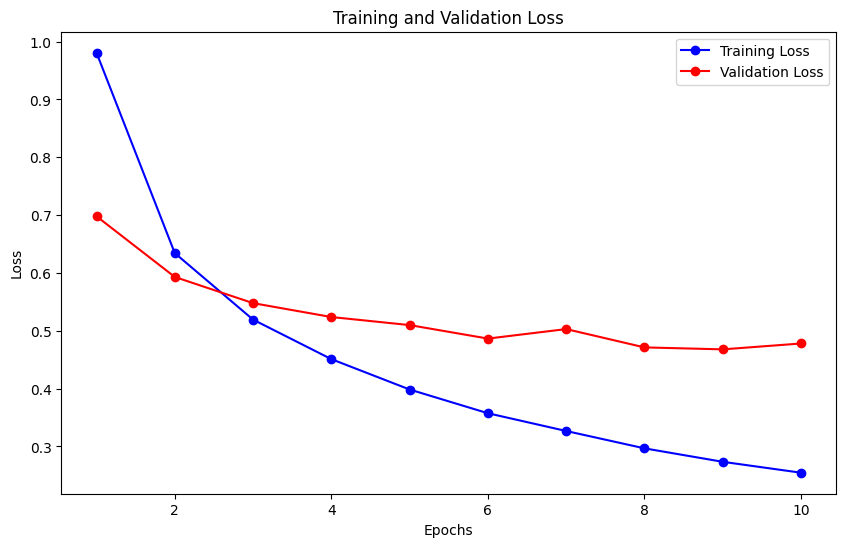

832/832 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8697 - loss: 0.5296
Test Accuracy: 0.8728065490722656
Test Loss: 0.5191590189933777
832/832 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


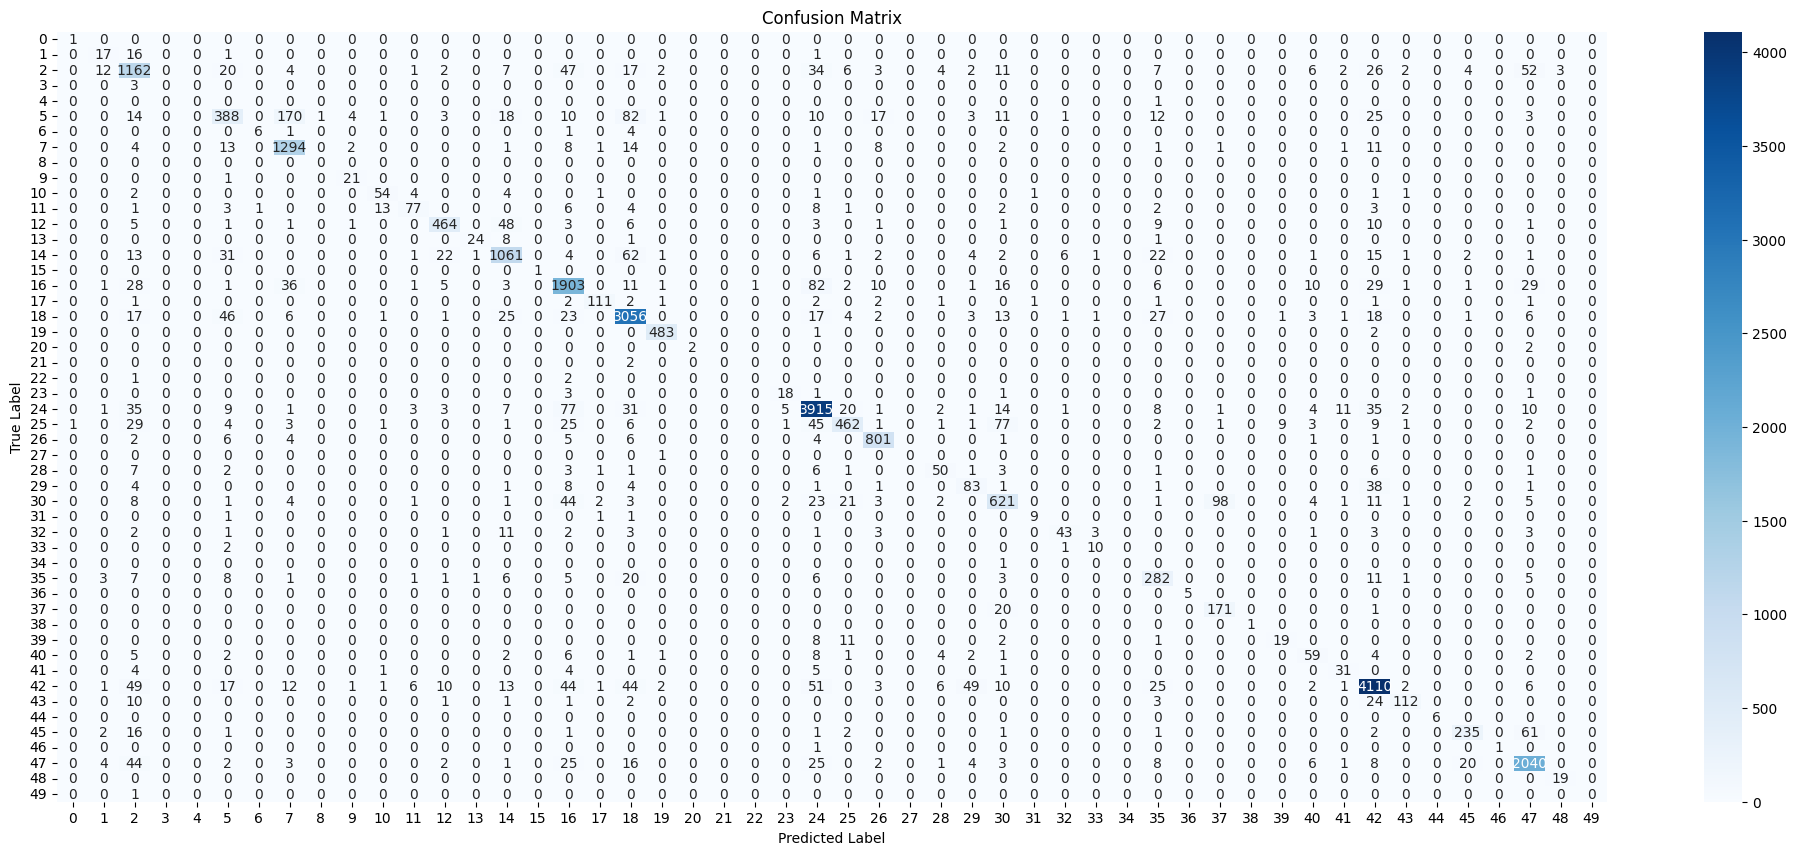

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced_text_transformer, encoded_y, test_size=0.2, random_state=42)
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

model = keras.Sequential([
  keras.layers.Dense(units=256, activation="relu"),  
  keras.layers.Dense(units=128, activation="relu"),  
  keras.layers.Dense(units=60, activation="softmax"),  
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(X_train_new, y_train_new, epochs=10, batch_size=32, validation_data=(X_val, y_val))

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Find test accuracy
test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

y_pred = model.predict(X_test)

# convert one-hot encoded prediction to class label prediciton
y_pred2 = np.argmax(y_pred, axis=1)
y_test2 = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_test2, y_pred2)

# Plot the confusion matrix
plt.figure(figsize=(25, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

For all three text-to-vector methods, we implemented printed the accuracy of a IvaM predictor model trained using only the text column. Furthermore, we also plotted the confusion matrices for all of these methods.